# BlogCatalog application: results from training, embedding dimension = 10, adj loss weight = 1000

## Imports and setup

In [1]:
import time
import random
import csv
from collections import defaultdict
import os
import pickle

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
import networkx as nx

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

import nw2vec
from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching
from nw2vec import graph
import settings

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
DATASET_PATH = settings.BLOGCATALOG_PATH + '/data'
RESULTS_PATH = settings.SCALE_PATH + '/blogcatalog'

### Load the BlogCatalog data

In [3]:
### Get the full list of nodes and groups ###

crop = None

# nodes
nodes = []
with open(DATASET_PATH + '/nodes.csv') as csvfile:
    reader = csv.reader(csvfile)
    nodes = [int(row[0]) for row in reader]
if crop is not None:
    nodes = nodes[:crop]
assert len(nodes) == len(set(nodes))
nodes = set(nodes)

# groups
groups = []
with open(DATASET_PATH + '/groups.csv') as csvfile:
    reader = csv.reader(csvfile)
    groups = [int(row[0]) for row in reader]
assert len(groups) == len(set(groups))
groups = set(groups)


### Generate graph from edges and node data ###

# Read edges.csv and make a network out of it
edges = defaultdict(list)
with open(DATASET_PATH + '/edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes and int(row[1]) in nodes:
                edges[int(row[0])].append(int(row[1]))
        else:
            edges[int(row[0])].append(int(row[1]))

g = nx.from_dict_of_lists(edges, create_using=nx.Graph())
if crop is not None:
    g.add_nodes_from(nodes)

# Read group-edges.csv and add that info to each node
group_edges = defaultdict(list)
with open(DATASET_PATH + '/group-edges.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if crop is not None:
            if int(row[0]) in nodes:
                group_edges[int(row[0])].append(int(row[1]))
        else:
            group_edges[int(row[0])].append(int(row[1]))

for node, data in g.nodes.items():
    data['groups'] = group_edges[node]


### Sanity checks ###
assert set(g.nodes) == nodes
#CROP
if crop is None:
    assert set().union(*[groups for _, groups in g.nodes(data='groups')]) == groups

And set the node labels

In [4]:
labels = np.zeros((len(nodes), len(groups)))
nodes_offset = min(nodes)
groups_offset = min(groups)
for n, data in g.nodes.items():
    labels[n - nodes_offset, np.array(data['groups']) - groups_offset] = 1

### Load the VAE model and training history

Define the VAE Parameters

In [5]:
n_nodes = len(nodes)
adj = nx.adjacency_matrix(g).astype(np.float32)

n_ξ_samples = 5
dim_data, dim_l1, dim_ξ = len(groups), 10, 10
dims = (dim_data, dim_l1, dim_ξ)
use_bias = False

loss_weights = [1.0, 1000.0, 1.0]

adj_cross_entropy_weighing = True
feature_reconstruction = True

Get the corresponding checkpoint and history filenames

In [6]:
filename_filters = ['crop={}'.format(crop),
                    'dims={}'.format(dims),
                    'bias={}'.format(use_bias),
                    'loss_weights={}'.format(loss_weights),
                    'n_epochs={}'.format(10000),
                    'adj_cross_entropy_weighing={}'.format(adj_cross_entropy_weighing),
                    'feature_reconstruction={}'.format(feature_reconstruction)]
checkpoint_filenames = list(filter(lambda s: s.endswith('.h5'), os.listdir(RESULTS_PATH)))
history_filenames = list(filter(lambda s: s.endswith('.pkl'), os.listdir(RESULTS_PATH)))
for f in filename_filters:
    checkpoint_filenames = list(filter(lambda s: f in s, checkpoint_filenames))
    history_filenames = list(filter(lambda s: f in s, history_filenames))

assert len(checkpoint_filenames) == 1
assert len(history_filenames) == 1
checkpoint_filename = checkpoint_filenames[0]
history_filename = history_filenames[0]

checkpoint_path = RESULTS_PATH + '/' + checkpoint_filename
history_path = RESULTS_PATH + '/' + history_filename

Load the model weights

In [7]:
q_model, q_codecs = ae.build_q(dims, use_bias=use_bias)
q_model.load_weights(checkpoint_path, by_name=True)

vae = keras.models.load_model(checkpoint_path,
                              custom_objects=nw2vec.custom_objects())

/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/slerique/anaconda3/envs/base36-grunchgpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Load the training history

In [8]:
with open(history_path, 'rb') as f:
    history = pickle.load(f)

## Results

### Training history

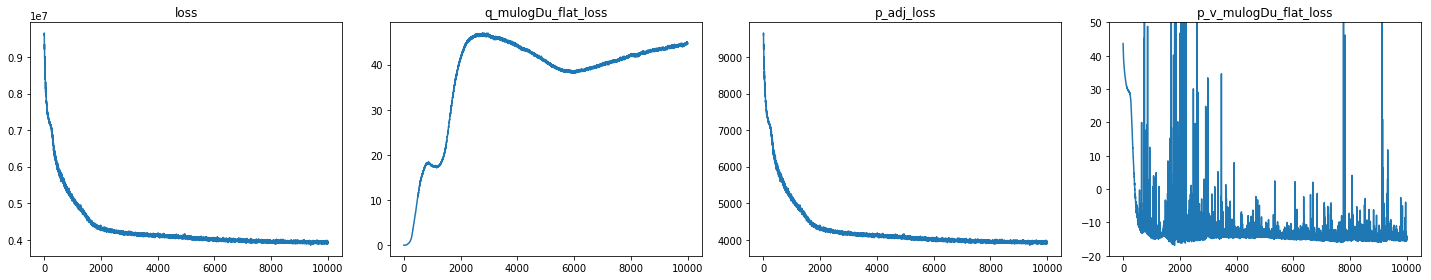

In [9]:
fig, axes = plt.subplots(1, len(history['history']), figsize=(len(history['history']) * 5, 4))
for i, (title, values) in enumerate(history['history'].items()):
    axes[i].plot(values)
    axes[i].set_title(title)
axes[-1].set_ylim(-20, 50)
fig.tight_layout()

### Embeddings

TODO:
- add colours representing the user topics? (several colors per dot...)

In [10]:
def target_func(batch_adj, required_nodes, final_nodes):
    return None

features = utils.scale_center(labels)
x, _, feeds = next(batching.batches(vae, adj, features, target_func,
                                    adj.shape[0], 1,
                                    p=1, q=1, neighbour_samples=None))
q_pred = q_model.predict_on_fed_batch(x, feeds=feeds)
embedding_codec = codecs.Gaussian(q_pred)

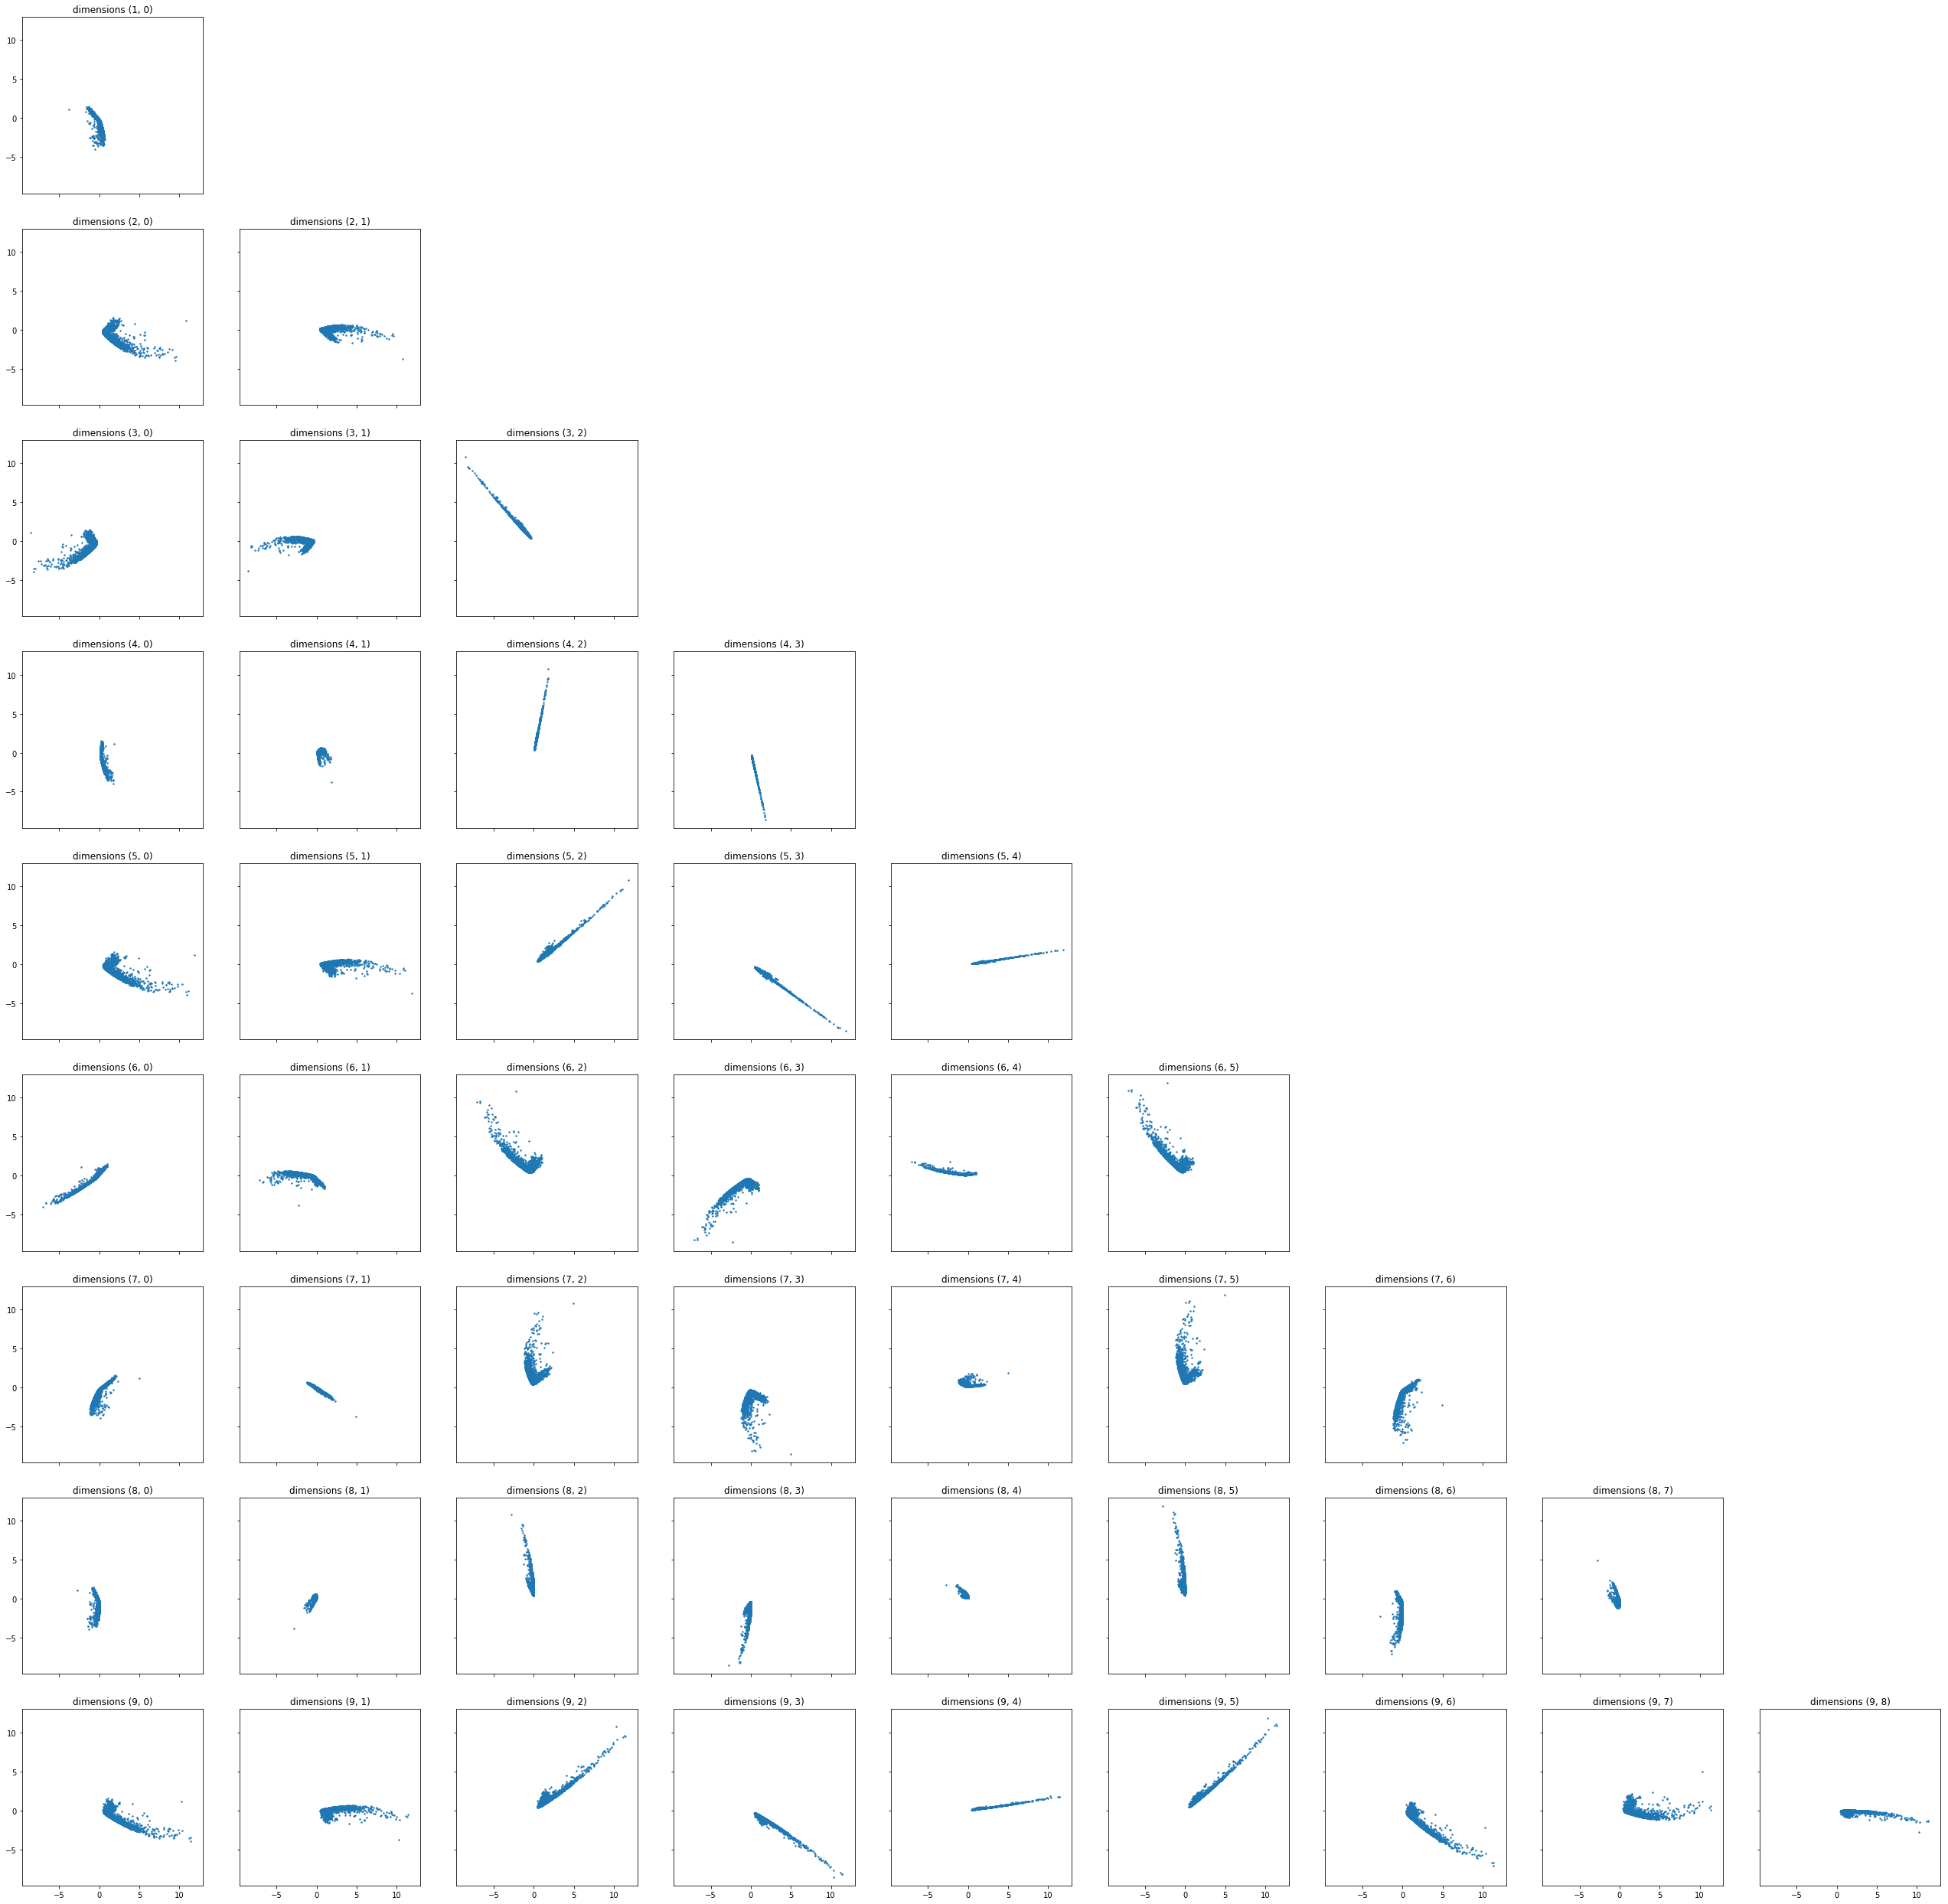

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(50, 50), sharex=True, sharey=True)
for i in range(10):
    for j in range(i):
        axes[i, j].scatter(q_pred[:, i], q_pred[:, j], s=2)
        axes[i, j].set_title("dimensions ({}, {})".format(i, j))
    for j in range(i, 10):
        axes[i, j].set_visible(False)

### [stratchpad] Uncertainty ellipses -- currently only works in dimension 2

In [12]:
#xlim = ax.get_xlim()
#ylim = ax.get_ylim()

In [13]:
#from scipy import linalg
#from matplotlib.patches import Ellipse, Circle
#from matplotlib.collections import PatchCollection

In [14]:
#R = K.eval(embedding_codec.R)
#R.min()

In [15]:
#C = R @ R.transpose([0, 2, 1])
#
#evals, evecs = zip(*[linalg.eigh(c) for c in C])
#evals = np.array(evals)
#evecs = np.array(evecs)
#
#e_widths = 3 * 2 * np.sqrt(evals[:, 0])
#e_heights = 3 * 2 * np.sqrt(evals[:, 1])
#e_angles = 180 * np.arctan(evecs[:, 0, 1] / evecs[:, 0, 0]) / np.pi

In [16]:
#ellipses = PatchCollection([Ellipse(q_pred[i, :2], e_widths[i], e_heights[i], e_angles[i])
#                            for i in range(n_nodes)],
#                           facecolor='blue', alpha=.1)
#
#fig, ax = plt.subplots(figsize=(5, 5))
#ax.add_artist(ellipses)
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

### Predicted adjacency matrix

Load the decoder model

In [17]:
p_input = keras.layers.Input(shape=(10,), name='p_input')
(p_adj, p_v), p_codecs = ae.build_p_builder(dims, use_bias=use_bias)(p_input)

p_model = keras.Model(inputs=p_input, outputs=[p_adj, p_v])
p_model.load_weights(checkpoint_path, by_name=True)

Make a model prediction

In [18]:
adj_preds, v_preds = zip(*[p_model.predict_on_batch(K.eval(embedding_codec.stochastic_value(1))[:, 0, :])
                           for _ in range(10)])

adj_preds = np.array(adj_preds)
v_preds = np.array(v_preds)

adj_pred = scipy.special.expit(adj_preds[:, 0, :, :]).mean(0)
v_pred = v_preds.mean(0)

Plot the real vs. reconstructed adjacency matrix

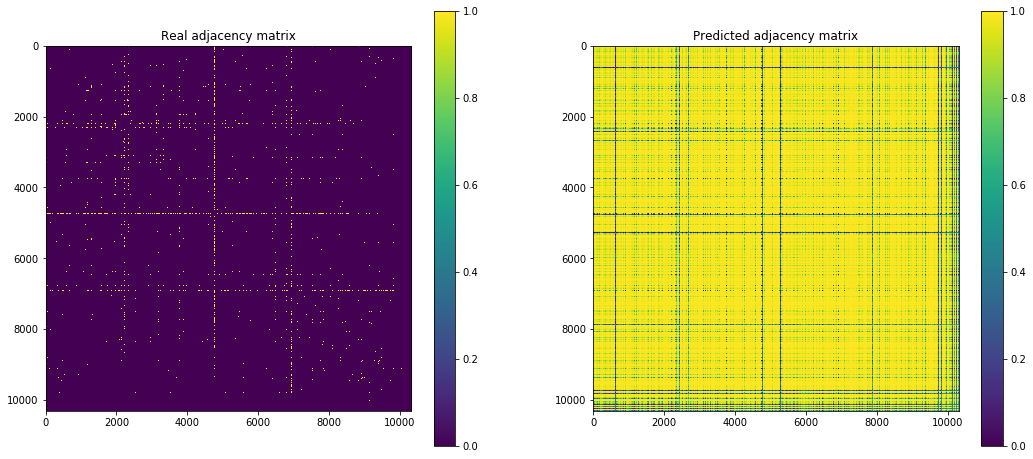

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

im1 = ax1.imshow(nx.adjacency_matrix(g).todense())
ax1.set_title('Real adjacency matrix')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(adj_pred)
im2.set_norm(im1.norm)
ax2.set_title('Predicted adjacency matrix')
plt.colorbar(im2, ax=ax2);

Sample a reconstructued adjacency matrix

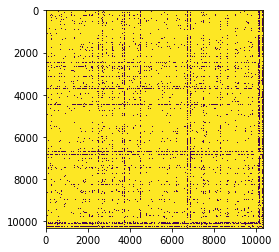

In [20]:
plt.imshow(np.random.binomial(1, adj_pred))

### All layer weights

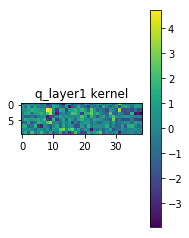

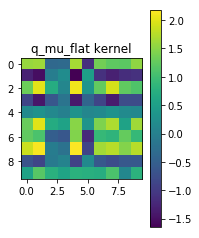

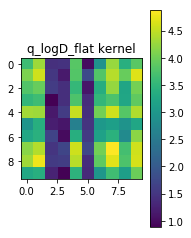

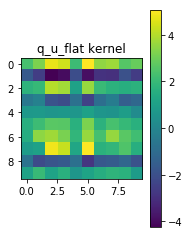

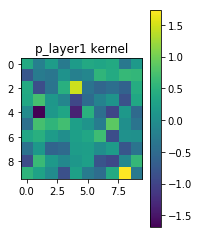

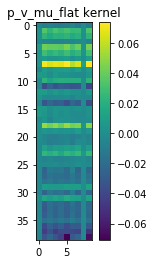

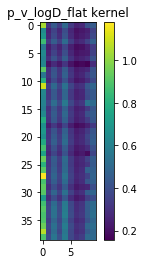

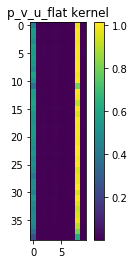

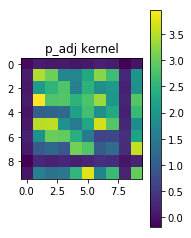

In [21]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
    if hasattr(layer, 'bias') and layer.bias is not None:
        im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
        ax2.set_title('{} bias'.format(layer.name))
        plt.colorbar(im2, ax=ax2)
    else:
        ax2.set_visible(False)